In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time
from reservoir import Reservoir
import data_utils

%load_ext autoreload
%autoreload 2
%aimport reservoir
%matplotlib inline
import matplotlib.pyplot as plt

# TODO: check if no boundery changes performance
def load_input_1(path, n_repeat=1):
    T_3D = np.load(path)[1:-1, :, :] # skipping the boundary layers
    x_dim, y_dim, sequence_length = T_3D.shape
    T_2D = T_3D.reshape((x_dim*y_dim, sequence_length)).T.reshape((1, sequence_length, x_dim*y_dim))
    T_2D_norm = np.tanh((T_2D-np.mean(T_2D))/np.std(T_2D))
    T_2D_norm = np.tile(T_2D_norm, (n_repeat, 1, 1))
    return T_3D, T_2D_norm

def load_input_2(path, n_repeat=1):
    T_3D = np.load(path)[1:-1, :, :] # skipping the boundary layers
    T_3D_norm = np.transpose(T_3D, axes=(0, 2, 1))
    T_3D_norm = np.tanh((T_3D_norm-np.mean(T_3D_norm))/np.std(T_3D_norm))
    T_3D_norm = np.tile(T_3D_norm, (n_repeat, 1, 1))
    return T_3D, T_3D_norm

def load_input_11(path, n_repeat=1):
    T_3D = np.load(path)[1:-1, :, :] # skipping the boundary layers
    x_dim, y_dim, sequence_length = T_3D.shape
    T_2D = T_3D.reshape((x_dim*y_dim, sequence_length)).T.reshape((1, sequence_length, x_dim*y_dim))
    T_2D_norm = (T_2D-np.mean(T_2D))/np.std(T_2D)
    T_2D_norm = np.tile(T_2D_norm, (n_repeat, 1, 1))
    return T_3D, T_2D_norm

def load_input_22(path, n_repeat=1):
    T_3D = np.load(path)[1:-1, :, :] # skipping the boundary layers
    T_3D_norm = np.transpose(T_3D, axes=(0, 2, 1))
    T_3D_norm = (T_3D_norm-np.mean(T_3D_norm))/np.std(T_3D_norm)
    T_3D_norm = np.tile(T_3D_norm, (n_repeat, 1, 1))
    return T_3D, T_3D_norm

def load_input_33(path, sequence_length=None, n_repeat=1):
    T_3D = np.load(path)[1:-1, :, :] # skipping the boundary layers
    
    if sequence_length is not None:
        T_3D_interp = np.zeros((T_3D.shape[0], T_3D.shape[1], sequence_length))
        sequence = np.arange(T_3D.shape[2])
        sequence_new = np.linspace(0, T_3D.shape[2], sequence_length)
        for xi in range(T_3D.shape[0]):
            for yi in range(T_3D.shape[1]):
                T_3D_interp[xi, yi, :] = np.interp(sequence_new, sequence, T_3D[xi, yi, :])
        T_3D = T_3D_interp
    
    x_dim, y_dim, sequence_length = T_3D.shape
    T_2D = T_3D.reshape((x_dim*y_dim, sequence_length)).T.reshape((1, sequence_length, x_dim*y_dim))
    T_2D_norm = (T_2D - (np.amax(T_2D) + np.amin(T_2D))/2)/((np.amax(T_2D) - np.amin(T_2D))/2)
    T_2D_norm = np.tile(T_2D_norm, (n_repeat, 1, 1))
    return T_3D, T_2D_norm

In [ ]:
# Input data
raw_train_data_2, train_data_2 = load_input_33(
    "2D_convection_datasets/x_y_temperature_deltaT_2.npy", sequence_length=5000, n_repeat = 1)
raw_train_data_4, train_data_4 = load_input_33(
    "2D_convection_datasets/x_y_temperature_deltaT_4.npy", sequence_length=5000, n_repeat = 1)
raw_train_data_6, train_data_6 = load_input_33(
    "2D_convection_datasets/x_y_temperature_deltaT_6.npy", sequence_length=5000, n_repeat = 1)
raw_train_data_8, train_data_8 = load_input_33(
    "2D_convection_datasets/x_y_temperature_deltaT_8.npy", sequence_length=5000, n_repeat = 1)
raw_train_data = np.concatenate((raw_train_data_2, raw_train_data_4, raw_train_data_6, raw_train_data_8))
train_data = np.concatenate((train_data_2, train_data_4, train_data_6, train_data_8))

n_sequence, sequence_length, spatial_points = train_data.shape
b = Reservoir(n_res=5000, res_scale=1, res_encoding='phase', res_enc_param=1.*np.pi,
              input_scale=1, input_encoding='phase', input_enc_param = 1.*np.pi,
              random_projection='simulation', weights_type='complex gaussian',
              activation_fun='intensity', activation_param=1,
              parallel_runs=n_sequence,  bias_scale=0.2, leak_rate=0.3,
              pred_horizon=100, rec_pred_steps=1, forget = 50,
              train_method='ridge', train_param=1e0, verbose=1
             )
# Algorithm training
b.fit(train_data);

Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 49.837077617645264 s
100%|██████████| 5000/5000 [04:01<00:00, 20.65it/s]
Reservoir iterations complete. 		Elapsed time: 241.75798177719116 s


In [ ]:
# testing data
raw_test_data, test_data = load_input_33(
    "2D_convection_datasets/x_y_temperature_deltaT_10.npy", sequence_length=5000, n_repeat = 1)
n_sequence, sequence_length, spatial_points = test_data.shape

# Algorithm testing
b.parallel_runs = n_sequence
pred_output, valid_score = b.predict_and_score(test_data, detailed_score=True)

## save/load the output weights

In [7]:
np.save('dumped_output_weights/output_weights_n_res_10000_n_pred_5', b.output_w)
b.output_w = np.load('dumped_output_weights/output_weights_n_res_10000_n_pred_5.npy')

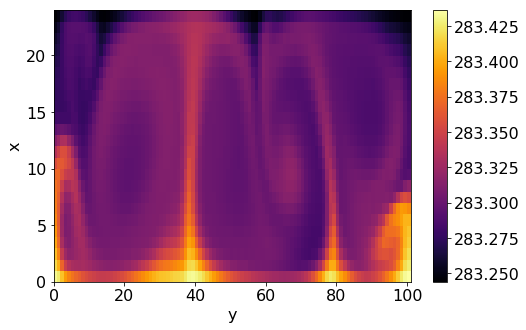

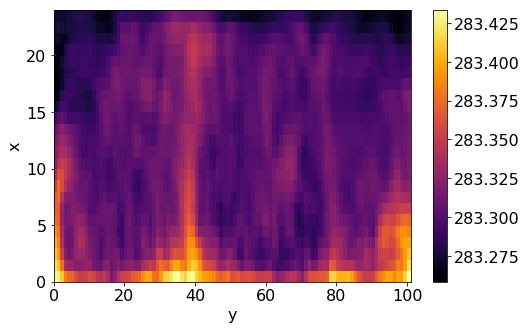

In [20]:
t = 4499
x_dim, y_dim, sequence_length = raw_test_data.shape
pred_output_ = pred_output.reshape(
    sequence_length-b.forget, b.pred_horizon, x_dim, y_dim)*np.std(raw_test_data) + np.mean(raw_test_data)
test_data_ = test_data[0, b.forget:].reshape(
    sequence_length-b.forget, x_dim, y_dim)*np.std(raw_test_data) + np.mean(raw_test_data)
plt.figure(1,figsize=(8,5))
im1 = plt.pcolormesh(test_data_[t+1, :, :], cmap='inferno')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar(im1)
plt.rcParams.update({'font.size': 16})
plt.savefig('original_t=4500.png', bbox_inches='tight', dpi=400)

plt.figure(2,figsize=(8,5))
im2 = plt.pcolormesh(pred_output_[t, 0, :, :], cmap='inferno')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar(im2)
plt.savefig('predicted_t=4500.png.png', bbox_inches='tight', dpi=400)

<function matplotlib.pyplot.show(*args, **kw)>

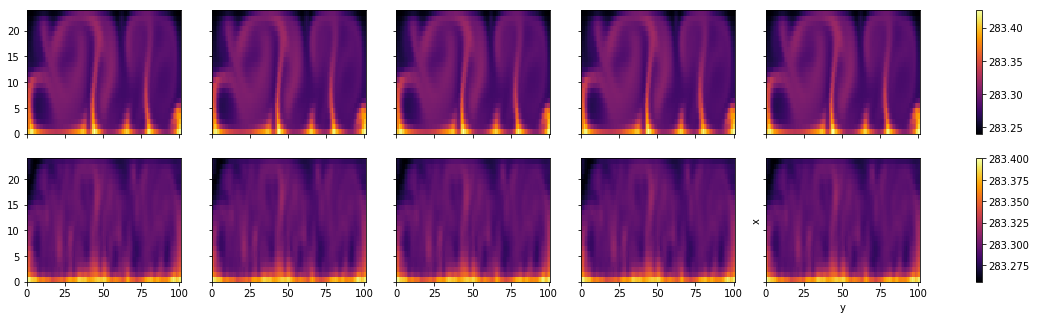

In [7]:
x_dim, y_dim, sequence_length = raw_test_data.shape
pred_output_ = pred_output.reshape(
    sequence_length-b.forget, b.pred_horizon, x_dim, y_dim)*np.std(raw_test_data) + np.mean(raw_test_data)
test_data_ = test_data[0, b.forget:].reshape(
    sequence_length-b.forget, x_dim, y_dim)*np.std(raw_test_data) + np.mean(raw_test_data)


t = 3000
fig, axs = plt.subplots(2, b.pred_horizon, sharey=True,sharex=True, figsize=(20,5))

for i in range(b.pred_horizon):
    im0 = axs[0, i].pcolormesh(test_data_[t+i+1, :, :], cmap='inferno')
    plt.ylabel('x')
    plt.xlabel('y')

for i in range(b.pred_horizon):
    im1 = axs[1, i].pcolormesh(pred_output_[t, i, :, :], cmap='inferno')
    plt.ylabel('x')
    plt.xlabel('y')
fig.colorbar(im0, ax=axs[0, :].ravel().tolist(), shrink=1)
fig.colorbar(im1, ax=axs[1, :].ravel().tolist(), shrink=1)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

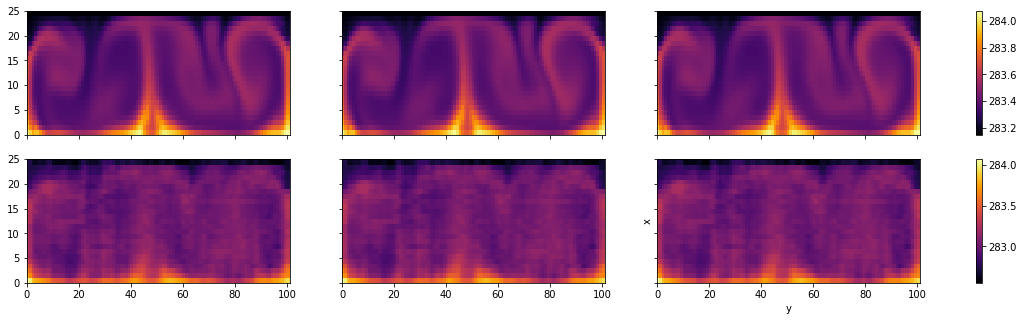

In [10]:
# test_data_ = np.arctanh(test_data)*np.std(raw_data) + np.mean(raw_data)
test_data_ = test_data*np.std(raw_data) + np.mean(raw_data)

# pred_output_ =  np.arctanh(
#     np.clip(pred_output, np.min(test_data), np.max(test_data)))*np.std(raw_data) + np.mean(raw_data)
pred_output_ =  pred_output*np.std(raw_data) + np.mean(raw_data)
pred_output_ = pred_output_.reshape((n_sequence, sequence_length-b.forget, b.pred_horizon, spatial_points))

t = 800
fig, axs = plt.subplots(2, b.pred_horizon, sharey=True,sharex=True, figsize=(20,5))

for i in range(b.pred_horizon):
    im0 = axs[0, i].pcolormesh(test_data_[:25, t+i+1, :], cmap='inferno')
    plt.ylabel('x')
    plt.xlabel('y')

for i in range(b.pred_horizon):
    im1 = axs[1, i].pcolormesh(pred_output_[:, t-b.forget, i, :], cmap='inferno')
    plt.ylabel('x')
    plt.xlabel('y')
fig.colorbar(im0, ax=axs[0, :].ravel().tolist(), shrink=1)
fig.colorbar(im1, ax=axs[1, :].ravel().tolist(), shrink=1)
plt.show


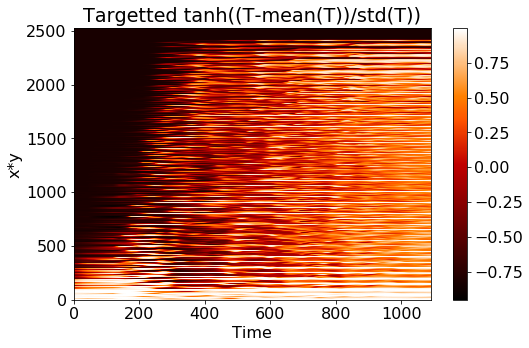

In [107]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(T_2D_concat[0, b.forget+10:, :].T, cmap='gist_heat')
plt.rcParams.update({'font.size': 16})
plt.title('Targetted tanh((T-mean(T))/std(T))')
plt.ylabel('x*y')
plt.xlabel('Time')
plt.colorbar(im)
plt.show
plt.savefig('Train.png', bbox_inches='tight', dpi=400)

<function matplotlib.pyplot.show(*args, **kw)>

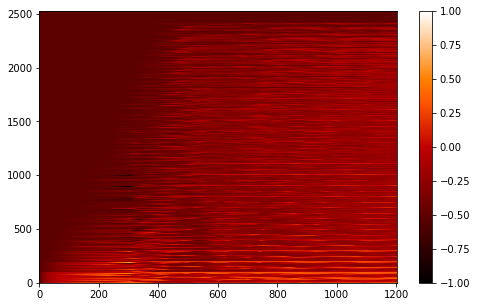

In [8]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(T_2D_norm[0].T, cmap='gist_heat')
plt.colorbar(im)
plt.show

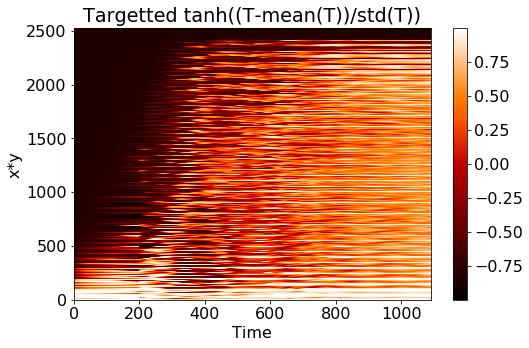

In [105]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(T_2D_concat[0, b.forget+10:, :].T, cmap='gist_heat')
plt.rcParams.update({'font.size': 16})
plt.title('Targetted tanh((T-mean(T))/std(T))')
plt.ylabel('x*y')
plt.xlabel('Time')
plt.colorbar(im)
plt.show
plt.savefig('Test.png', bbox_inches='tight', dpi=400)

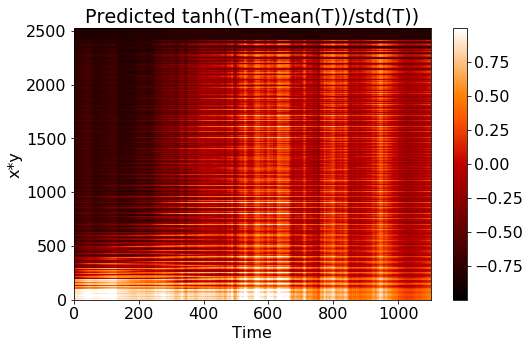

In [104]:
P = pred_output[:, 0*spatial_points:1*spatial_points]
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(P.T, cmap='gist_heat',vmin=np.min(T_2D_concat), vmax=np.max(T_2D_concat))
plt.rcParams.update({'font.size': 16})
plt.title('Predicted tanh((T-mean(T))/std(T))')
plt.ylabel('x*y')
plt.xlabel('Time')
plt.colorbar(im)
plt.show
plt.savefig('Prediction.png', bbox_inches='tight', dpi=400)

In [173]:
np.std(true_data)

0.6200098559943764

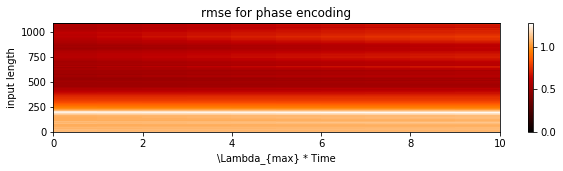

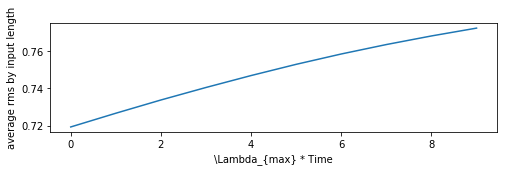

In [176]:
# prediction RMSE

test_data_ = np.arctanh(test_data)*np.std(raw_data) + np.mean(raw_data)
pred_output_ = np.arctanh(np.clip(pred_output, 1e-4, 1- 1e-4))*np.std(raw_data) + np.mean(raw_data)


total_pred = b.pred_horizon*b.rec_pred_steps
true_data = test_data_[:, b.forget:, :]
true_data_std = np.std(true_data) # think about better normalization
true_data_norm = true_data/true_data_std
pred_output_norm = pred_output_.reshape((n_sequence, sequence_length-b.forget, b.pred_horizon, spatial_points))/true_data_std
length_input = pred_output_norm.shape[1] - total_pred
rmse = np.zeros((length_input, total_pred))
for n_input in range(1, length_input):
    for n_pred in range(1, total_pred+1):
        d1 = true_data_norm[:, n_input:n_input+n_pred, :]
        d2 = pred_output_norm[:, n_input-1, 0:n_pred, :]
        
        rmse[n_input-1, n_pred-1] = np.sqrt(1./(n_pred*spatial_points*n_sequence)*np.sum((d1.flatten() - d2.flatten())**2))

plt.figure(1,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(rmse[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

plt.figure(2,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(np.mean(rmse[:,:], axis=0))
plt.show;
# np.save('SLM_timesteps_20000.npy', np.sum(rmse[:,1:], axis=0)/length_input)

In [171]:
total_pred = b.pred_horizon*b.rec_pred_steps
n_input = 200 #round(pred_output.shape[0]/2-300)
input_data = T_2D_concat[0, :n_input+b.forget, :]
prediction = pred_output[n_input, :].reshape(-1, spatial_points)
targetted_data = T_2D_concat[0, n_input+b.forget:n_input+b.forget+total_pred, :]

vmax = np.amax(abs(np.concatenate((targetted_data, input_data, prediction))))
vmin = np.min(abs(np.concatenate((targetted_data, input_data, prediction))))

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
for i in range(3):
    im=axs[i].pcolormesh(datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

plt.figure(3,figsize=(9,2.5))
im=plt.pcolormesh(datum[3].T, cmap='gray')
plt.colorbar(im)
# # plt.savefig('DND_input_data.png')

NameError: name 'T_2D_concat' is not defined